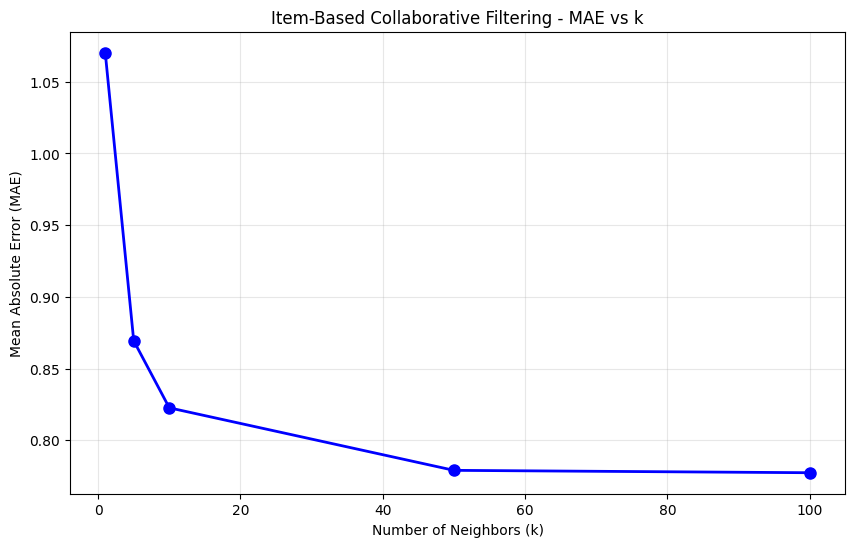

Summary of Results:
k	MAE
---------------
1	1.0702
5	0.8694
10	0.8227
50	0.7791
100	0.7775


In [2]:
import pandas as pd
import numpy as np
import time
import scipy as sp
from scipy import sparse
import matplotlib.pyplot as plt

num_users = 943
num_items = 1682



# load training set from file
df_training = pd.read_csv('u1.base', sep='\t', names=['User ID', 'Movie ID', 'Rating', 'Timestamp'])

values = df_training.values
values[:, 0:2] -= 1

# build the sparse rating matrix for training set
data = values[:, 2]
rows = values[:, 0]
cols = values[:, 1]
sp_training = sparse.csr_matrix((data, (rows, cols)), shape=(num_users, num_items), dtype=np.float64)



# load test set
df_test = pd.read_csv('u1.test', sep='\t', names=['User ID', 'Movie ID', 'Rating', 'Timestamp'])
values = df_test.values
values[:, 0:2] -= 1

data = values[:, 2]
rows = values[:, 0]
cols = values[:, 1]
sp_test = sparse.csr_matrix((data, (rows, cols)), shape=(num_users, num_items), dtype=np.float64)



# User mean normalization for item-based CF

start = time.time()

sp_training_copy = sp_training.copy()

# Calculate user means and normalize ratings
for u in range(sp_training_copy.shape[0]):
    # Get user's ratings
    user_ratings = sp_training_copy.getrow(u)
    nonzero_indices = user_ratings.nonzero()[1]

    if len(nonzero_indices) > 0:
        ratings = user_ratings.data
        mean_rating = ratings.mean()

        # Subtract user mean from ratings
        for idx, item_idx in enumerate(nonzero_indices):
            sp_training_copy[u, item_idx] -= mean_rating

end = time.time()



# Compute item-item similarity using cosine similarity

start = time.time()

# Convert to dense for easier computation (or use sparse operations for large datasets)
normalized_matrix = sp_training_copy.toarray()

# Compute item-item dot products
item_similarity = np.zeros((num_items, num_items))

for i in range(num_items):
    for j in range(i, num_items):
        # Get items that both items i and j have been rated by
        item_i = normalized_matrix[:, i]
        item_j = normalized_matrix[:, j]

        # Find users who rated both items
        common_users = (item_i != 0) & (item_j != 0)

        if np.sum(common_users) > 0:
            ratings_i = item_i[common_users]
            ratings_j = item_j[common_users]

            # Cosine similarity
            norm_i = np.linalg.norm(ratings_i)
            norm_j = np.linalg.norm(ratings_j)

            if norm_i > 0 and norm_j > 0:
                similarity = np.dot(ratings_i, ratings_j) / (norm_i * norm_j)
                item_similarity[i, j] = similarity
                item_similarity[j, i] = similarity

end = time.time()


# Store user means for prediction
user_means = np.zeros(num_users)
for u in range(num_users):
    user_ratings = sp_training.getrow(u)
    if user_ratings.nnz > 0:
        user_means[u] = user_ratings.data.mean()


# Predict rating using item-based CF
def predict(user, item, k):
    # Get user's rated items
    user_ratings = sp_training.getrow(user)
    rated_items = user_ratings.nonzero()[1]

    if len(rated_items) == 0:
        return user_means[user] if user_means[user] > 0 else 3.0  # Global default

    # Get similarities between target item and user's rated items
    similarities = item_similarity[item, rated_items]

    # Get the actual ratings (not normalized)
    actual_ratings = user_ratings.data

    # Sort by similarity and take top k
    if len(similarities) > 0:
        # Get indices sorted by similarity (descending)
        sorted_indices = np.argsort(similarities)[::-1]

        # Take top k similar items
        k = min(k, len(sorted_indices))
        top_k_indices = sorted_indices[:k]

        top_k_similarities = similarities[top_k_indices]
        top_k_ratings = actual_ratings[top_k_indices]

        # Remove items with zero or negative similarity
        positive_sim_mask = top_k_similarities > 0
        if np.sum(positive_sim_mask) > 0:
            top_k_similarities = top_k_similarities[positive_sim_mask]
            top_k_ratings = top_k_ratings[positive_sim_mask]

            # Weighted average
            if np.sum(np.abs(top_k_similarities)) > 0:
                prediction = np.dot(top_k_similarities, top_k_ratings) / np.sum(np.abs(top_k_similarities))
                return prediction

    # Fallback to user mean
    return user_means[user] if user_means[user] > 0 else 3.0

# test MAE
def computeMAE(k):
    start = time.time()
    MAE = 0.0
    rows, cols = sp_test.nonzero()

    for j in range(len(rows)):
        actual = sp_test[rows[j], cols[j]]
        predicted = predict(rows[j], cols[j], k)
        MAE += abs(actual - predicted)

        if j % 100 == 0:
            end = time.time()


    MAE /= len(rows)
    print()
    return MAE

def test():
    k_values = [1, 5, 10, 50, 100]
    MAEs = []

    for k in k_values:

        MAE = computeMAE(k)
        MAEs.append(MAE)

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, MAEs, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('Item-Based Collaborative Filtering - MAE vs k')
    plt.grid(True, alpha=0.3)
    plt.show()

     # Print results table
    print("Summary of Results:")
    print("k\tMAE")
    print("-" * 15)
    for k, mae in zip(k_values, MAEs):
        print(f"{k}\t{mae:.4f}")

if __name__ == '__main__':
    test()
